In [1]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
from pandas.io.json import json_normalize

In [2]:
# Two data sets were compiled and used for this data story
# The primary goal was to determine how often and when odds change leading up to when an MLB contest begins
# The data sets used were odds changes from April, 2016 for MLB baseball (354 games)
# Also used was a file containing 164,751 instances of odds 'snapshots' in json format from Spring Training, 2017 (3/14-3/22)

In [3]:
# First data set is contained in one .csv file
df = pd.read_csv('capstone/mlb-4.1.2016-4.30.2016-2.csv', encoding='utf-8', header=None)

In [4]:
# eliminate header rows
df = df[2:]

In [5]:
# rename heading columns
heading_row = ['date', 'time','ml-fav', 'ml-dog','rl-fav', 'rl-dog','total-over', 'total-under',
               '1st-half-fav', '1st-half-dog','2nd-half-fav', '2nd-half-dog','filename']
df.columns = heading_row

In [6]:
# reset index
df = df.reset_index(drop=True)
df.head()

,date,time,ml-fav,ml-dog,rl-fav,rl-dog,total-over,total-under,1st-half-fav,1st-half-dog,2nd-half-fav,2nd-half-dog,filename
0,30-Mar,4:25pm,PIT-116,STL+106,STL-210,PIT+180,6.5 -105,6.5 -115,NaN,NaN,NaN,NaN,0001.csv
1,30-Mar,5:40pm,PIT-116,STL+106,STL-210,PIT+180,6.5 +100,6.5 -120,NaN,NaN,NaN,NaN,0001.csv
2,31-Mar,3:15pm,PIT-110,STL+100,STL-210,PIT+180,6.5 +105,6.5 -125,NaN,NaN,NaN,NaN,0001.csv
3,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5 +100,6.5 -120,NaN,NaN,NaN,NaN,0001.csv
4,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5 +100,6.5 -120,STL-119,PIT-101,NaN,NaN,0001.csv


In [7]:
# the following two lines eliminate the whitespace that is contained in the total-over and total-under columns
df['total-over'] = df['total-over'].str.replace(' ','').str.replace(' ','')
df['total-under'] = df['total-under'].str.replace(' ','').str.replace(' ','')

In [8]:
# these commands are used to create boolean values for whether or not each relevant column changed
# we are only looking at changes for: ml (moneyline, odds to win), rl (run line, odds to win or lose by 1 1/2 runs)...
# ...and totals (total runs scored, over or under a particular value)
df['ml-fav-change'] = (df.duplicated(['filename']) & (df['ml-fav'] != df['ml-fav'].shift(1)))
df['ml-dog-change'] = (df.duplicated(['filename']) & (df['ml-dog'] != df['ml-dog'].shift(1)))
df['rl-fav-change'] = (df.duplicated(['filename']) & (df['rl-fav'] != df['rl-fav'].shift(1)))
df['rl-dog-change'] = (df.duplicated(['filename']) & (df['rl-dog'] != df['rl-dog'].shift(1)))
df['total-over-change'] = (df.duplicated(['filename']) & (df['total-over'] != df['total-over'].shift(1)))
df['total-under-change'] = (df.duplicated(['filename']) & (df['total-under'] != df['total-under'].shift(1)))

In [9]:
df.head()

,date,time,ml-fav,ml-dog,rl-fav,rl-dog,total-over,total-under,1st-half-fav,1st-half-dog,2nd-half-fav,2nd-half-dog,filename,ml-fav-change,ml-dog-change,rl-fav-change,rl-dog-change,total-over-change,total-under-change
0,30-Mar,4:25pm,PIT-116,STL+106,STL-210,PIT+180,6.5-105,6.5-115,NaN,NaN,NaN,NaN,0001.csv,False,False,False,False,False,False
1,30-Mar,5:40pm,PIT-116,STL+106,STL-210,PIT+180,6.5+100,6.5-120,NaN,NaN,NaN,NaN,0001.csv,False,False,False,False,True,True
2,31-Mar,3:15pm,PIT-110,STL+100,STL-210,PIT+180,6.5+105,6.5-125,NaN,NaN,NaN,NaN,0001.csv,True,True,False,False,True,True
3,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5+100,6.5-120,NaN,NaN,NaN,NaN,0001.csv,True,True,True,True,True,True
4,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5+100,6.5-120,STL-119,PIT-101,NaN,NaN,0001.csv,False,False,False,False,False,False


In [12]:
# this is a count of how many odds changes occurred for each contest, which can also be exported if need be
df.groupby(['filename'])[['ml-fav-change','ml-dog-change','rl-fav-change','rl-dog-change',
                          'total-over-change','total-under-change']].sum()

,ml-fav-change,ml-dog-change,rl-fav-change,rl-dog-change,total-over-change,total-under-change
filename,,,,,,
0001.csv,33.0,33.0,21.0,16.0,15.0,15.0
0002.csv,32.0,33.0,9.0,9.0,14.0,14.0
0003.csv,36.0,36.0,16.0,16.0,9.0,9.0
0004.csv,14.0,11.0,11.0,11.0,17.0,17.0
0005.csv,12.0,12.0,5.0,5.0,11.0,11.0
0006.csv,14.0,14.0,12.0,11.0,7.0,7.0
0007.csv,12.0,16.0,5.0,5.0,13.0,13.0
0008.csv,20.0,14.0,5.0,5.0,7.0,7.0
0009.csv,9.0,9.0,4.0,4.0,5.0,5.0


In [13]:
# below is the average number of changes in odds for each category: moneyline, runline, total
df.groupby(['filename'])[['ml-fav-change','ml-dog-change','rl-fav-change','rl-dog-change',
                          'total-over-change','total-under-change']].sum().mean()

ml-fav-change         17.759887
ml-dog-change         17.737288
rl-fav-change         10.977401
rl-dog-change         10.734463
total-over-change     10.454802
total-under-change    10.454802
dtype: float64

In [20]:
# after determining the number of odds changes, we may want to determine when they generally occur
# columns were added to the dataframe to help with this determination
df['date-time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d-%b %I:%M%p')
# adding 42,369 days to each date was necessary, as the original .csv file did not contain the year
df['date-time'] = df['date-time'] + pd.to_timedelta(42369,unit='d')

In [21]:
# opening and closing time for odds added to each row
df['opening-time'] = df['date-time'].groupby(df['filename']).transform('min')
df['closing-time'] = df['date-time'].groupby(df['filename']).transform('max')
df['open-close-dif'] = df['closing-time'] - df['opening-time']

In [22]:
# this adds a percentage time to each row of how close to the beginning of the contest the given row occurred
df['percent-time-to-close'] = (1 - ((df['closing-time'] - df['date-time']) / df['open-close-dif']))

In [23]:
# date literal time columns show the amount of time in days and in float value where 1 day = 1
df['date-literal-time-to-close'] = df['open-close-dif'] * (1 - df['percent-time-to-close'])
df['date-literal-time-to-close-float'] = df['date-literal-time-to-close'] / np.timedelta64(1,'D')

In [24]:
df.head()

,date,time,ml-fav,ml-dog,rl-fav,rl-dog,total-over,total-under,1st-half-fav,1st-half-dog,...,rl-dog-change,total-over-change,total-under-change,date-time,opening-time,closing-time,open-close-dif,percent-time-to-close,date-literal-time-to-close,date-literal-time-to-close-float
0,30-Mar,4:25pm,PIT-116,STL+106,STL-210,PIT+180,6.5-105,6.5-115,NaN,NaN,...,False,False,False,2016-03-30 16:25:00,2016-03-30 16:25:00,2016-04-03 13:05:00,3 days 20:40:00,0.000000,3 days 20:40:00,3.861111
1,30-Mar,5:40pm,PIT-116,STL+106,STL-210,PIT+180,6.5+100,6.5-120,NaN,NaN,...,False,True,True,2016-03-30 17:40:00,2016-03-30 16:25:00,2016-04-03 13:05:00,3 days 20:40:00,0.013489,3 days 19:25:00,3.809028
2,31-Mar,3:15pm,PIT-110,STL+100,STL-210,PIT+180,6.5+105,6.5-125,NaN,NaN,...,False,True,True,2016-03-31 15:15:00,2016-03-30 16:25:00,2016-04-03 13:05:00,3 days 20:40:00,0.246403,2 days 21:50:00,2.909722
3,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5+100,6.5-120,NaN,NaN,...,True,True,True,2016-03-31 15:55:00,2016-03-30 16:25:00,2016-04-03 13:05:00,3 days 20:40:00,0.253597,2 days 21:10:00,2.881944
4,31-Mar,3:55pm,STL-114,PIT+104,PIT-190,STL+165,6.5+100,6.5-120,STL-119,PIT-101,...,False,False,False,2016-03-31 15:55:00,2016-03-30 16:25:00,2016-04-03 13:05:00,3 days 20:40:00,0.253597,2 days 21:10:00,2.881944


In [25]:
# a new dataframe is now created to examine only rows with changes
# this subset contains 12,079 of the original 18,801 rows
dfChangeInAny = df[(df['ml-fav-change'] == True) | (df['ml-dog-change'] == True) | 
                   (df['rl-fav-change'] == True) | (df['rl-dog-change'] == True) | 
                   (df['total-over-change'] == True) | (df['total-under-change'] == True)]
dfChangeInAny = dfChangeInAny.reset_index(drop=True)

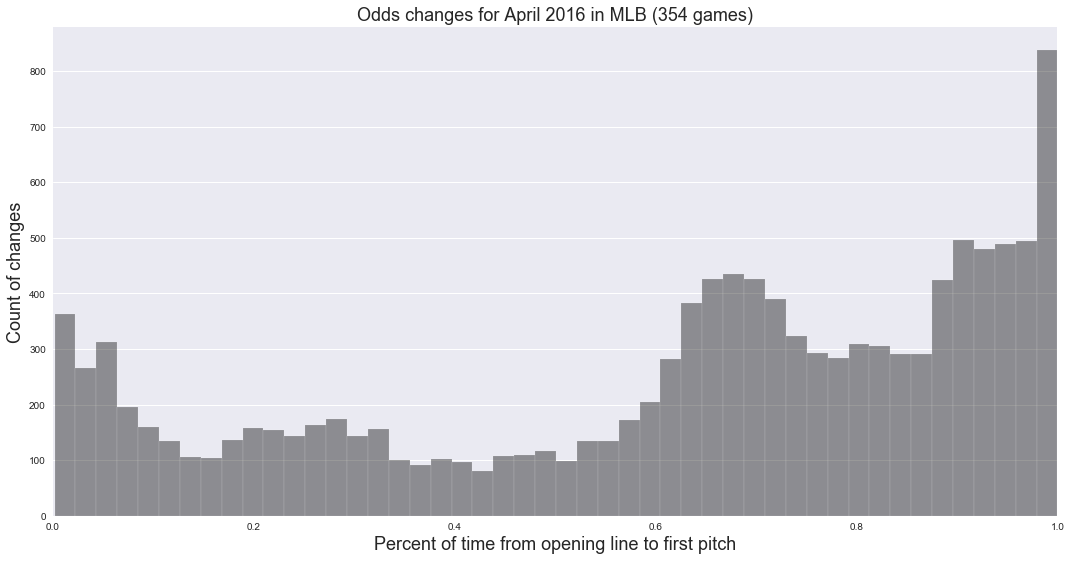

In [26]:
# first attempt at a histogram counts odds changes as a percentage of time left until the contest beings
plt.figure(figsize=(18, 9))

ax = plt.gca()
ax.yaxis.grid(True)
ax.xaxis.grid(False)

g = sns.distplot(dfChangeInAny['percent-time-to-close'], bins=48, kde=False, 
                 hist_kws={"color": "black", "edgecolor": "white"})
g.set(xlim=(0, 1.0))

plt.xlabel('Percent of time from opening line to first pitch', fontsize=18)
plt.ylabel('Count of changes', fontsize=18)
plt.title('Odds changes for April 2016 in MLB (354 games)', fontsize=18)

g

In [27]:
# after examining the data, it appeared that the changes could be 'normalized' into a 24 hour period prior to the contest start
# this way, 96 bins could be used, with each bin representing a 15 minute interval
# a new dataframe will be used for this histogram; this subset (changes occurring 1 day or less prior to start)...
# ...still contained a fair number of changes: 10,376 changes from the 'changes only' dataframe of 12,079
dfChangeInAnyOneDayOnly = dfChangeInAny[dfChangeInAny['date-literal-time-to-close-float'] <= 1]
dfChangeInAnyOneDayOnly = dfChangeInAnyOneDayOnly.reset_index(drop=True)

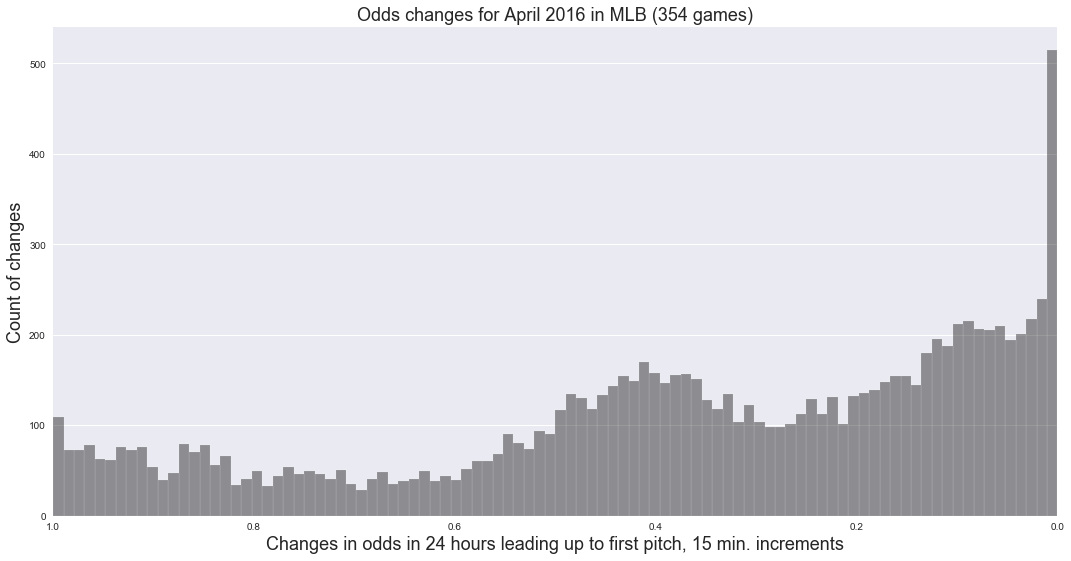

In [28]:
# most useful chart below: when do the changes occur?
# as expected, in the 15 minutes leading up to the start of the contest, the changes are most frequent
plt.figure(figsize=(18, 9))

ax = plt.gca()
ax.yaxis.grid(True)
ax.xaxis.grid(False)

g = sns.distplot(dfChangeInAnyOneDayOnly['date-literal-time-to-close-float'], bins=96, kde=False, 
                 hist_kws={"color": "black", "edgecolor": "white"})
g.set(xlim=(1.0, 0))

plt.xlabel('Changes in odds in 24 hours leading up to first pitch, 15 min. increments', fontsize=18)
plt.ylabel('Count of changes', fontsize=18)
plt.title('Odds changes for April 2016 in MLB (354 games)', fontsize=18)

g

In [29]:
# other interesting observations about the above chart:
# the spike in changes seen near 0.4 (0.4 x 1440 where 1440 is the number of minutes in a day...)
# this equates to around 9 1/2 hours prior to the start of the game
# these changes are likely due to volume occurring in the morning for contests starting at 7 pm EST...
# and also afternoon activity for contests starting at 10 pm EST
# also, 2 hours and 15 minutes prior to first pitch shows another spike in changes - most lineups are set by this time

In [31]:
# spring training data actually did not yield much insight as changes in odds were very infrequent
# since spring training games don't count for anything, these would be difficult to speculate on
# steps for examining the data and making this determination are below

In [32]:
# also note, the file containing json odds for spring training...
# ...was not uploaded to github - it is 105 MB and I have it stored locally if you want to look at it

In [2]:
df2017 = pd.read_json('data/mlbcontests', lines=True)

In [34]:
df2017

,AwayPitcher,AwayROT,AwayTeam,Details,HomePitcher,HomeROT,HomeTeam,ID,MatchTime,Odds,Sport,_id
0,Jacob deGrom,957,New York Mets,MLB,Lance McCullers Jr.,958,Houston Astros,39b312be-ae42-4771-8680-54303816eda2,2017-03-14T17:05:00,[{'ID': '39b312be-ae42-4771-8680-54303816eda2'...,0,{'$oid': '58c774664e9d9808e0f99c9f'}
1,Aaron Blair,955,Atlanta Braves,MLB,Jerad Eickhoff,956,Philadelphia Phillies,4b1b0bb0-8b43-4662-891e-2b5eeaab11db,2017-03-14T17:05:00,[{'ID': '4b1b0bb0-8b43-4662-891e-2b5eeaab11db'...,0,{'$oid': '58c774664e9d9808e0f99ca0'}
2,,953,Toronto Blue Jays,MLB,Drew Pomeranz,954,Boston Red Sox,b1406ec0-affa-4d6b-ab12-488b32bf1884,2017-03-14T17:05:00,[{'ID': 'b1406ec0-affa-4d6b-ab12-488b32bf1884'...,0,{'$oid': '58c774664e9d9808e0f99ca1'}
3,Matt Boyd,951,Detroit Tigers,MLB,,952,Miami Marlins,f36822bc-50af-4af6-ab01-a9f54db9f6c4,2017-03-14T17:05:00,[{'ID': 'f36822bc-50af-4af6-ab01-a9f54db9f6c4'...,0,{'$oid': '58c774664e9d9808e0f99ca2'}
4,Zach Davies,965,Milwaukee Brewers,MLB,Brett Anderson,966,Chicago Cubs,12ce5709-f9b2-413f-b929-077a94898fdc,2017-03-14T20:05:00,[{'ID': '12ce5709-f9b2-413f-b929-077a94898fdc'...,0,{'$oid': '58c774664e9d9808e0f99ca3'}
5,,967,Cincinnati Reds,MLB,Rich Hill,968,Los Angeles Dodgers,20f87a0a-9140-4baa-bf81-c30b888d2dce,2017-03-14T20:05:00,[{'ID': '20f87a0a-9140-4baa-bf81-c30b888d2dce'...,0,{'$oid': '58c774664e9d9808e0f99ca4'}
6,Jon Gray,963,Colorado Rockies,MLB,Sean Manaea,964,Oakland Athletics,5bdb895b-0ffc-4412-87e5-f83dec769eb1,2017-03-14T20:05:00,[{'ID': '5bdb895b-0ffc-4412-87e5-f83dec769eb1'...,0,{'$oid': '58c774664e9d9808e0f99ca5'}
7,,961,San Francisco Giants,MLB,Josh Tomlin,962,Cleveland Indians,5c055aa9-0a36-4d89-8057-8eb17070d38d,2017-03-14T20:05:00,[{'ID': '5c055aa9-0a36-4d89-8057-8eb17070d38d'...,0,{'$oid': '58c774664e9d9808e0f99ca6'}
8,Matt Shoemaker,959,Los Angeles Angels,MLB,Ian Kennedy,960,Kansas City Royals,81b0112a-b569-4319-bffb-00ce3ba4a282,2017-03-14T20:05:00,[{'ID': '81b0112a-b569-4319-bffb-00ce3ba4a282'...,0,{'$oid': '58c774664e9d9808e0f99ca7'}
9,Lucas Giolito,971,Chicago White Sox,MLB,James Paxton,972,Seattle Mariners,381c860e-95f5-4399-9de6-73f4e4aa3cf6,2017-03-14T20:10:00,[{'ID': '381c860e-95f5-4399-9de6-73f4e4aa3cf6'...,0,{'$oid': '58c774664e9d9808e0f99ca8'}


In [3]:
# note - odds must be extracted; after doing this, I concatenated them to the original df
data = []
with open('data/mlbcontests') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
result_odds = json_normalize(data, 'Odds')

In [37]:
result_odds

,DrawLine,EventID,ID,LastUpdated,MoneyLineAway,MoneyLineHome,OddType,OverLine,PointSpreadAway,PointSpreadAwayLine,PointSpreadHome,PointSpreadHomeLine,SiteID,TotalNumber,UnderLine
0,0,39b312be-ae42-4771-8680-54303816eda2,39b312be-ae42-4771-8680-54303816eda2,2017-03-14T04:34:07,-112,-108,Game,0,0.0,0,0.0,0,3,0.0,0
1,0,4b1b0bb0-8b43-4662-891e-2b5eeaab11db,4b1b0bb0-8b43-4662-891e-2b5eeaab11db,2017-03-14T04:34:07,100,-120,Game,0,0.0,0,0.0,0,3,0.0,0
2,0,b1406ec0-affa-4d6b-ab12-488b32bf1884,b1406ec0-affa-4d6b-ab12-488b32bf1884,2017-03-14T04:34:07,110,-130,Game,0,0.0,0,0.0,0,3,0.0,0
3,0,f36822bc-50af-4af6-ab01-a9f54db9f6c4,f36822bc-50af-4af6-ab01-a9f54db9f6c4,2017-03-14T04:34:07,100,-120,Game,0,0.0,0,0.0,0,3,0.0,0
4,0,12ce5709-f9b2-413f-b929-077a94898fdc,12ce5709-f9b2-413f-b929-077a94898fdc,2017-03-14T04:34:07,130,-150,Game,0,0.0,0,0.0,0,3,0.0,0
5,0,20f87a0a-9140-4baa-bf81-c30b888d2dce,20f87a0a-9140-4baa-bf81-c30b888d2dce,2017-03-14T04:34:07,120,-140,Game,0,0.0,0,0.0,0,3,0.0,0
6,0,5bdb895b-0ffc-4412-87e5-f83dec769eb1,5bdb895b-0ffc-4412-87e5-f83dec769eb1,2017-03-14T04:34:07,105,-125,Game,0,0.0,0,0.0,0,3,0.0,0
7,0,5c055aa9-0a36-4d89-8057-8eb17070d38d,5c055aa9-0a36-4d89-8057-8eb17070d38d,2017-03-14T04:34:07,110,-130,Game,0,0.0,0,0.0,0,3,0.0,0
8,0,81b0112a-b569-4319-bffb-00ce3ba4a282,81b0112a-b569-4319-bffb-00ce3ba4a282,2017-03-14T04:34:07,105,-125,Game,0,0.0,0,0.0,0,3,0.0,0
9,0,381c860e-95f5-4399-9de6-73f4e4aa3cf6,381c860e-95f5-4399-9de6-73f4e4aa3cf6,2017-03-14T04:34:07,115,-135,Game,0,0.0,0,0.0,0,3,0.0,0


In [5]:
df2017 = pd.concat([df2017, result_odds], axis=1)
df2017 = df2017.drop('Odds', 1)

In [6]:
# because the spring training odds were collected every minute, there are a lot of duplicates
# removing the duplicates reduces the number of rows from 164,751 to 27,364
df2017 = df2017.drop_duplicates(subset=['EventID','LastUpdated'])
df2017 = df2017.sort_values(by=['EventID','LastUpdated'])
df2017 = df2017.reset_index(drop=True)
df2017

,AwayPitcher,AwayROT,AwayTeam,Details,HomePitcher,HomeROT,HomeTeam,ID,MatchTime,Sport,...,MoneyLineHome,OddType,OverLine,PointSpreadAway,PointSpreadAwayLine,PointSpreadHome,PointSpreadHomeLine,SiteID,TotalNumber,UnderLine
0,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
1,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
2,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
3,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
4,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
5,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
6,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
7,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
8,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0
9,NaN,921,Chicago White Sox,None,NaN,922,Texas Rangers,01e48c34-7fdb-4110-9659-8636ebd724e3,2017-03-22T01:05:00,0,...,-135,Game,0,0.0,0,0.0,0,3,0.0,0


In [7]:
# these are the change columns - only the moneyline changes during spring training, there is no runline or total odds
df2017['MoneyLineAway-change'] = (df2017.duplicated(['EventID']) & (df2017['MoneyLineAway'] != df2017['MoneyLineAway'].shift(1)))
df2017['MoneyLineHome-change'] = (df2017.duplicated(['EventID']) & (df2017['MoneyLineHome'] != df2017['MoneyLineHome'].shift(1)))

In [8]:
# notice the small number of changes per contest - less than 4, compared to over four times this many for regular season contests
df2017.groupby(['EventID'])['MoneyLineAway-change'].sum().mean()

3.9482758620689653

In [9]:
# at this point, it was determined that the spring training data was rather useless
# but the regular season begins on April 2 and we are still collecting odds changes by minute
# this data should prove useful soon